In [1]:
!pip -q install torchcodec --index-url "https://download.pytorch.org/whl/cu126"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.4 MB/s eta 0:00:00


In [41]:

import os, gc, torch
os.environ["USE_TF"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.cuda.empty_cache(); gc.collect()

print("PyTorch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())


PyTorch: 2.8.0+cu126 | CUDA available: True


In [ ]:
from pathlib import Path
import json, random, math
from typing import List, Dict, Any, Optional, Tuple

import numpy as np
import torch, torchaudio
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoFeatureExtractor, AutoConfig, Wav2Vec2Model
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ==== USER SETTINGS ====
DRIVE_MOUNTED = True
DATA_DIR     = "/content/drive/MyDrive/Colab_Drive_Files/Worker1"   # folder with .wav or .mp3 + matching .json
if not DRIVE_MOUNTED:
    DATA_DIR = "./Data"
TARGET_KEYS  = ["Valence_best","Arousal_best","Submissive_vs._Dominant_best", "Serious_vs._Humorous_best"]
MODEL_NAME   = "facebook/wav2vec2-base-960h"  # small & stable; upgrade later if needed
TARGET_SR    = 16_000
MAX_SECONDS  = 12.0              # keep modest; you can try more later
SEED         = 42

# Training
EPOCHS       = 30                # start small
LR           = 1e-3             # higher LR since we train only a tiny head
WEIGHT_DECAY = 0.0
BATCH_SIZE   = 1                # keep at 1 for stability
NUM_WORKERS  = 0                # 0 = no multiprocessing (stable on Colab)
VAL_SPLIT    = 0.1              # if N>1, take ~10% for val
MAX_FILES    = None             # set an int (e.g., 200) for a smoke test; None = all

random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [47]:
# Normalization based on label ranges of different attributes
ALL_KEYS_WITH_RANGE = {
  "Valence_best": { "min": -3, "max": 3 },
  "Arousal_best": { "min": 0, "max": 4 },
  "Submissive_vs._Dominant_best": { "min": -3, "max": 3 },
  "Age_best": { "min": 0, "max": 6 },
  "Gender_best": { "min": -2, "max": 2 },
  "Serious_vs._Humorous_best": { "min": 0, "max": 4 },
  "Vulnerable_vs._Emotionally_Detached_best": { "min": 0, "max": 4 },
  "Confident_vs._Hesitant_best": { "min": 0, "max": 4 },
  "Warm_vs._Cold_best": { "min": -2, "max": 2 },
  "Monotone_vs._Expressive_best": { "min": 0, "max": 4 },
  "High-Pitched_vs._Low-Pitched_best": { "min": 0, "max": 4 },
  "Soft_vs._Harsh_best": { "min": -2, "max": 2 },
  "Authenticity_best": { "min": 0, "max": 4 },
  "Recording_Quality_best": { "min": 0, "max": 4 },
  "Background_Noise_best": { "min": 0, "max": 3 }
}

def normalize_range(value, attribute):
    min_value = ALL_KEYS_WITH_RANGE[attribute]["min"]
    max_value = ALL_KEYS_WITH_RANGE[attribute]["max"]
    return (value - min_value) / (max_value - min_value)
def denormalize_range(value, attribute):
    min_value = ALL_KEYS_WITH_RANGE[attribute]["min"]
    max_value = ALL_KEYS_WITH_RANGE[attribute]["max"]
    return value * (max_value - min_value) + min_value

In [48]:
import json
from pathlib import Path
import torch
from typing import List

# Audio and emotions will be lazy initialized, and also store their output of the base encoder

# Assuming normalize_range, load_first_n_seconds, TARGET_KEYS, TARGET_SR, MAX_SECONDS, fe, device are defined in the global scope

class LazyAudioData:
    def __init__(self, audio_path: str, json_path: str):
        self._audio_path = audio_path
        self._json_path = json_path
        self._emotions = None  # To store cached emotions
        self._wav = None       # To store cached waveform
        self._encoded_features = None # To store cached encoded features

    @property
    def emotions(self) -> List[float]:
        if self._emotions is None:
            # Load and normalize emotions from JSON using global TARGET_KEYS and normalize_range
            try:
                emo = json.loads(Path(self._json_path).read_text(encoding="utf-8")).get("emotion_annotation", {})
                labels = [normalize_range(float(emo[k]), k) for k in TARGET_KEYS]
                if not all(np.isfinite(labels)):
                    raise ValueError("Non-finite labels found after normalization")
                if isinstance(labels, torch.Tensor):
                    labels = labels.unsqueeze(0)          # (1, D)
                else:
                    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(0)
                labels = labels.to(device)
                self._emotions = labels
            except Exception as e:
                print(f"Warning: Error loading emotions from {self._json_path}: {e}")
                self._emotions = [] # Return empty list on error
        return self._emotions

    @property
    def wav(self) -> torch.Tensor:
        if self._wav is None:
            # Load waveform using the existing global function and parameters
            try:
                self._wav = load_first_n_seconds(self._audio_path, TARGET_SR, MAX_SECONDS)
            except Exception as e:
                print(f"Warning: Error loading audio from {self._audio_path}: {e}")
                self._wav = torch.empty(0) # Return empty tensor on error
        return self._wav

    @property
    def encoded_features(self):
        if self._encoded_features is None:
            # Ensure wav is loaded first
            if self._wav is None:
                _ = self.wav # Trigger wav loading
            if self._wav is not None and self._wav.numel() > 0:
                # Process wav through feature extractor (global `fe`)
                # Feat should be moved to device for consistency with batch_to_inputs
                feat = fe(self._wav, sampling_rate=TARGET_SR, return_tensors="pt", padding="do_not_pad")

                # TODO THESE ARE ENCODE INPUTS, NOT FEATURES
                inputs = {k: v.to(device) for k, v in feat.items()}

                with torch.no_grad():
                    out = encoder(input_values=inputs["input_values"])
                    self._encoded_features = out.last_hidden_state  # (B, T', d_model)
                # dont keep the large wavs
                del self._wav
                self._wav = None
            else:
                self._encoded_features = {} # Return empty dict if no wav or error
        return self._encoded_features

print("LazyAudioData class defined.")

LazyAudioData class defined.


In [49]:
def collect_pairs(data_dir: str, target_keys: List[str], limit: Optional[int]=None):
    root = Path(data_dir)
    files = sorted(root.rglob("*.mp3"))
    items = []
    for mp3 in files:
        j = mp3.with_suffix(".json")
        if not j.exists():
            continue
        items.append(LazyAudioData(str(mp3), str(j)))
    if not items:
        raise RuntimeError("No usable (audio,json) pairs found.")
    return items

items = collect_pairs(DATA_DIR, TARGET_KEYS, limit=MAX_FILES)
random.shuffle(items)

# Split
n = len(items)
if n == 1:
    train_items, val_items = items, []
else:
    n_val = min(max(1, int(n * VAL_SPLIT)), n-1)
    val_items, train_items = items[:n_val], items[n_val:]

print(f"pairs total={n}  train={len(train_items)}  val={len(val_items)}")

pairs total=2404  train=2164  val=240


In [50]:
MAX_LEN = int(TARGET_SR * MAX_SECONDS)
_resamplers: Dict[Tuple[int,int], torchaudio.transforms.Resample] = {}

def load_first_n_seconds(path: str, target_sr: int, max_seconds: float) -> torch.Tensor:
    # infer original SR without decoding full file
    try:
        info = torchaudio.info(path)
        orig_sr = info.sample_rate
    except Exception:
        _, orig_sr = torchaudio.load(path, frame_offset=0, num_frames=1024)
    frames = int(orig_sr * max_seconds)

    # read only that window
    wav, sr = torchaudio.load(path, frame_offset=0, num_frames=frames)  # (C, T<=frames)

    # mono
    if wav.shape[0] > 1:
        wav = wav.mean(0, keepdim=True)
    # resample minimal window
    if sr != target_sr:
        key = (sr, target_sr)
        if key not in _resamplers:
            _resamplers[key] = torchaudio.transforms.Resample(sr, target_sr)
        wav = _resamplers[key](wav)
    wav = wav.squeeze(0)

    # truncate/pad to EXACT MAX_LEN (so we can use padding="do_not_pad")
    if wav.numel() > MAX_LEN:
        wav = wav[:MAX_LEN]
    if wav.numel() < MAX_LEN:
        wav = torch.nn.functional.pad(wav, (0, MAX_LEN - wav.numel()))

    # peak normalize
    wav = wav / (wav.abs().max() + 1e-9)
    return wav


In [51]:
class PathDataset(Dataset):
    def __init__(self, items: List[Dict[str,Any]]):
        self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, idx):
        ex = self.items[idx]
        return {"encodedFeatures": ex.encoded_features, "labels": ex.emotions}

train_ds = PathDataset(train_items)
val_ds   = PathDataset(val_items) if len(val_items) else None

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=False, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=False, drop_last=False) if val_ds else None

print("Loaders ready.")


Loaders ready.


In [52]:
# Feature extractor & encoder (frozen)
fe = AutoFeatureExtractor.from_pretrained(MODEL_NAME, sampling_rate=TARGET_SR)
enc_cfg = AutoConfig.from_pretrained(MODEL_NAME, output_hidden_states=False)
encoder = Wav2Vec2Model.from_pretrained(MODEL_NAME, config=enc_cfg).to(device)
encoder.eval()
for p in encoder.parameters():
    p.requires_grad = False

# Tiny temporal head: GRU + attention pooling -> 3 outputs
class TemporalHead(nn.Module):
    def __init__(self, d_model=768, hidden=128, out_dim=len(TARGET_KEYS)):
        super().__init__()
        self.gru = nn.GRU(d_model, hidden, num_layers=1, batch_first=True, bidirectional=True)
        self.att = nn.Sequential(
            nn.Linear(2*hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, 1)
        )
        self.out = nn.Sequential(
            nn.LayerNorm(2*hidden),
            nn.Linear(2*hidden, out_dim), nn.Sigmoid()
        )
    def forward(self, hs):                 # hs: (B, T', d_model)
        z, _ = self.gru(hs)                # (B, T', 2H)
        a = self.att(z).squeeze(-1)        # (B, T')
        w = torch.softmax(a, dim=1).unsqueeze(-1)
        pooled = (w * z).sum(dim=1)        # (B, 2H)
        return self.out(pooled)            # (B, out_dim)

num_labels = len(TARGET_KEYS)
head = TemporalHead(d_model=encoder.config.hidden_size, hidden=128, out_dim=num_labels).to(device)

# Only head is trainable
opt = torch.optim.AdamW(head.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
mse = nn.MSELoss()
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

print("Encoder frozen. Trainable head params:",
      sum(p.numel() for p in head.parameters() if p.requires_grad))


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Encoder frozen. Trainable head params: 724229


/tmp/ipython-input-4152996174.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


In [ ]:
def batch_to_inputs(batch):
    """
    Accepts either:
      - list of dicts (when using a no-op collate_fn), or
      - dict with batched fields (PyTorch default collate)
    and returns (inputs_dict, labels_tensor) with batch size 1.
    """
    # Extract path + labels for a single-sample batch
    if isinstance(batch, list):
        ex = batch[0]
        encoded = ex.encoded_features()
        labels = ex.labels()
        if isinstance(labels, torch.Tensor):
            labels = labels.unsqueeze(0)          # (1, D)
        else:
            labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(0)
    labels = labels.to(device)
    return encoded, labels

def labels_to_acceptable(labels):
    if isinstance(labels, torch.Tensor):
        labels = labels.unsqueeze(0)          # (1, D)
    else:
        labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(0)
    return labels.to(device)

def run_epoch(loader, train=True):
    if train:
        head.train()
    else:
        head.eval()
    total_loss = 0.0
    n_items = 0
    # batch is only one sample
    for batch in loader:
        hs, labels = batch["encodedFeatures"].squeeze(0), batch["labels"] #batch_to_inputs(batch)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            preds = head(hs)
            loss = mse(preds, labels)
        if train:
            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        total_loss += loss.item() * labels.size(0)
        n_items += labels.size(0)
        # free ASAP
        # del inputs, labels, hs, preds, loss
        torch.cuda.empty_cache()
    return total_loss / max(1, n_items)

with torch.no_grad():
     va_loss = run_epoch(val_loader, train=False)
     print(f"Epoch {0}/{EPOCHS} | val MSE={va_loss:.4f}")
for epoch in range(1, EPOCHS+1):
    tr_loss = run_epoch(train_loader, train=True)
    if val_loader:
        with torch.no_grad():
            va_loss = run_epoch(val_loader, train=False)
        print(f"Epoch {epoch}/{EPOCHS} | train MSE={tr_loss:.4f} | val MSE={va_loss:.4f}")
    else:
        print(f"Epoch {epoch}/{EPOCHS} | train MSE={tr_loss:.4f}")


/tmp/ipython-input-315879173.py:7: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  info = torchaudio.info(path)
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:20: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s = torchaudio.io.Str

Epoch 0/30 | val MSE=0.0673
Epoch 1/30 | train MSE=0.0076 | val MSE=0.0056
Epoch 2/30 | train MSE=0.0063 | val MSE=0.0048
Epoch 3/30 | train MSE=0.0059 | val MSE=0.0046
Epoch 4/30 | train MSE=0.0055 | val MSE=0.0060
Epoch 5/30 | train MSE=0.0051 | val MSE=0.0044
Epoch 6/30 | train MSE=0.0047 | val MSE=0.0053
Epoch 7/30 | train MSE=0.0044 | val MSE=0.0045
Epoch 8/30 | train MSE=0.0039 | val MSE=0.0048
Epoch 9/30 | train MSE=0.0037 | val MSE=0.0051
Epoch 10/30 | train MSE=0.0034 | val MSE=0.0050
Epoch 11/30 | train MSE=0.0031 | val MSE=0.0052
Epoch 12/30 | train MSE=0.0028 | val MSE=0.0047
Epoch 13/30 | train MSE=0.0026 | val MSE=0.0049
Epoch 14/30 | train MSE=0.0025 | val MSE=0.0050
Epoch 15/30 | train MSE=0.0023 | val MSE=0.0048
Epoch 16/30 | train MSE=0.0020 | val MSE=0.0049
Epoch 17/30 | train MSE=0.0020 | val MSE=0.0055
Epoch 18/30 | train MSE=0.0019 | val MSE=0.0052
Epoch 19/30 | train MSE=0.0018 | val MSE=0.0053
Epoch 20/30 | train MSE=0.0016 | val MSE=0.0052
Epoch 21/30 | train M

In [1]:
def ccc(y_true, y_pred):
    y = np.asarray(y_true, np.float64)
    x = np.asarray(y_pred, np.float64)
    vx, vy = x.var(), y.var()
    mx, my = x.mean(), y.mean()
    cov = ((x - mx) * (y - my)).mean()
    denom = vx + vy + (mx - my)**2
    return float(2 * cov / denom) if denom > 0 else 0.0

def evaluate_full(loader):
    y_true, y_pred = [], []
    head.eval()
    with torch.no_grad():
        for batch in loader:
            inputs, labels = batch_to_inputs(batch)
            hs = encode(inputs)
            preds = head(hs)
            y_true.append(labels.detach().cpu().numpy())
            y_pred.append(preds.detach().cpu().numpy())
            del inputs, labels, hs, preds
            torch.cuda.empty_cache()
    Y = np.concatenate(y_true, axis=0)
    P = np.concatenate(y_pred, axis=0)
    mae = mean_absolute_error(Y, P, multioutput="raw_values")
    mse = mean_squared_error(Y, P, multioutput="raw_values")
    metrics = {
        "MAE_macro": float(mae.mean()),
        "MSE_macro": float(mse.mean()),
    }
    for i,k in enumerate(TARGET_KEYS):
        metrics[f"MAE_{k}"] = float(mae[i])
        metrics[f"MSE_{k}"] = float(mse[i])
        metrics[f"CCC_{k}"] = ccc(Y[:,i], P[:,i])
    return metrics

if val_loader and len(val_ds) > 0:
    metrics = evaluate_full(val_loader)
    print("Validation metrics:")
    for k,v in metrics.items():
        print(f"  {k}: {v:.4f}")
else:
    print("No validation split; skipped metrics.")


NameError: name 'val_loader' is not defined

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import joblib, json
SAVE_DIR = "/content/w2v2_temporal_head"
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

# Save torch head
torch.save(head.state_dict(), f"{SAVE_DIR}/temporal_head.pt")
# Save config to rebuild pipeline later
json.dump({
    "model_name": MODEL_NAME,
    "target_sr": TARGET_SR,
    "max_seconds": MAX_SECONDS,
    "target_keys": TARGET_KEYS,
    "head": {"d_model": int(encoder.config.hidden_size), "hidden": 128, "out_dim": len(TARGET_KEYS)}
}, open(f"{SAVE_DIR}/config.json","w"))

print("Saved to", SAVE_DIR)


Saved to /content/w2v2_temporal_head


In [ ]:
items = collect_pairs(DATA_DIR, TARGET_KEYS, limit=MAX_FILES)
random.shuffle(items)

# Split
n = len(items)
if n == 1:
    train_items, val_items = items, []
else:
    n_val = min(max(1, int(n * VAL_SPLIT)), n-1)
    val_items, train_items = items[:n_val], items[n_val:]

print(f"pairs total={n}  train={len(train_items)}  val={len(val_items)}")

pairs total=561  train=505  val=56


Attribute Distribution Statistics (Denormalized):
  Valence_best: Mean = 0.1259, Std Dev = 0.4080
  Arousal_best: Mean = 1.0970, Std Dev = 0.4033
  Submissive_vs._Dominant_best: Mean = 0.1447, Std Dev = 0.2482
  Serious_vs._Humorous_best: Mean = 0.7049, Std Dev = 0.4107

Attribute Distribution Statistics (Normalized):
  Valence_best: Mean = 0.5210, Std Dev = 0.0680
  Arousal_best: Mean = 0.2742, Std Dev = 0.1008
  Submissive_vs._Dominant_best: Mean = 0.5241, Std Dev = 0.0414
  Serious_vs._Humorous_best: Mean = 0.1762, Std Dev = 0.1027


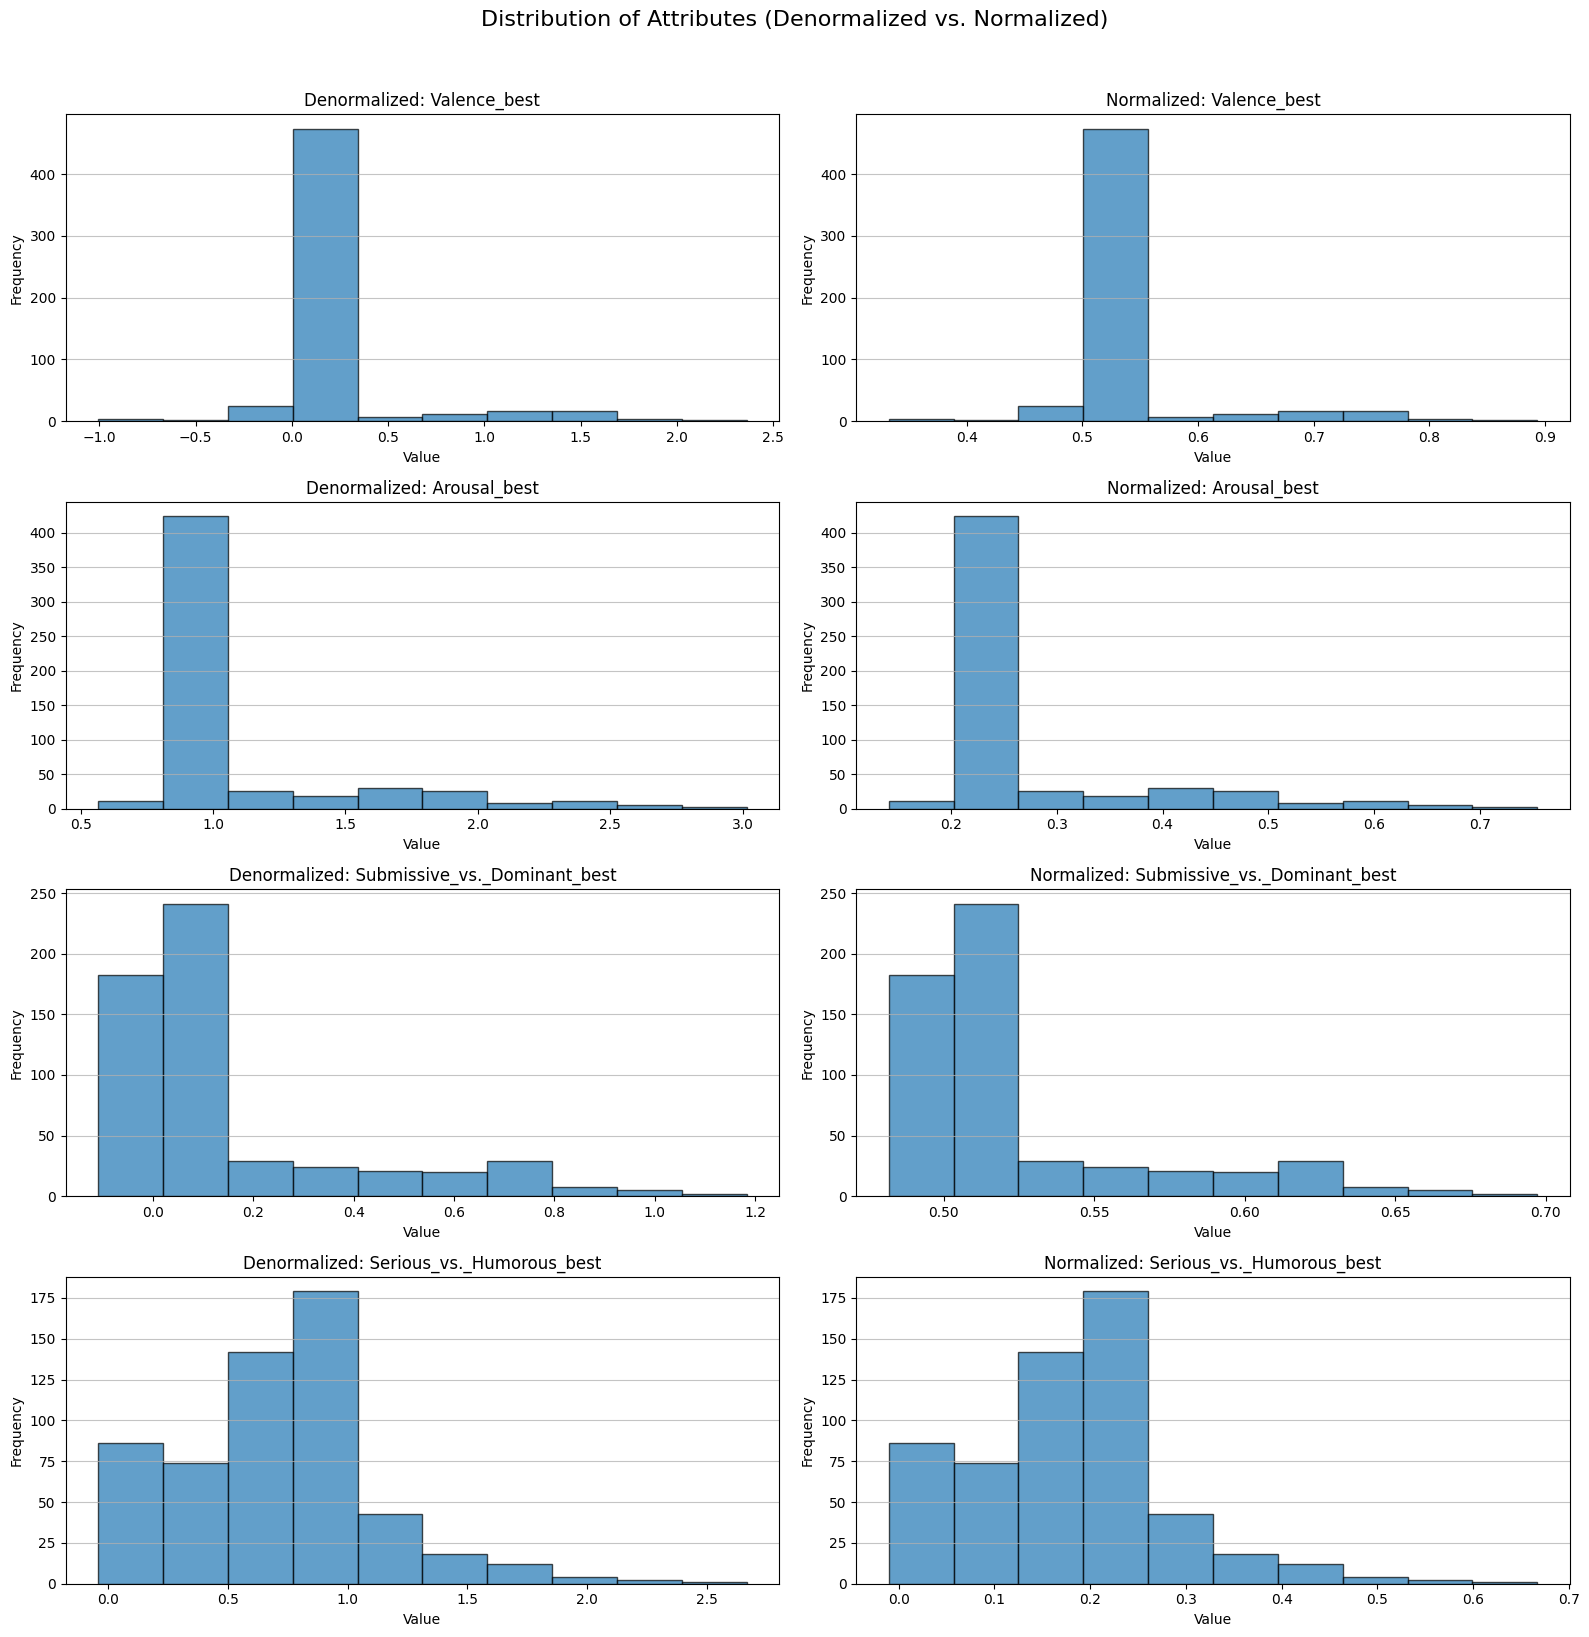

In [ ]:
import matplotlib.pyplot as plt

# Prepare to store denormalized labels for each target key
denormalized_labels = {key: [] for key in TARGET_KEYS}
normalized_labels = {key: [] for key in TARGET_KEYS}

# Iterate through items and denormalize labels
for item in items:
    for i, label_value in enumerate(item["labels"]):
        key = TARGET_KEYS[i]
        denormalized_value = denormalize_range(label_value, key)
        denormalized_labels[key].append(denormalized_value)
        normalized_labels[key].append(label_value) # Store normalized values as well

# Calculate and print mean and std for each attribute
print("Attribute Distribution Statistics (Denormalized):")
for key, values in denormalized_labels.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"  {key}: Mean = {mean_val:.4f}, Std Dev = {std_val:.4f}")

print("\nAttribute Distribution Statistics (Normalized):")
for key, values in normalized_labels.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"  {key}: Mean = {mean_val:.4f}, Std Dev = {std_val:.4f}")

# Visualize distributions using histograms
num_keys = len(TARGET_KEYS)
fig, axes = plt.subplots(num_keys, 2, figsize=(16, 4 * num_keys))
fig.suptitle('Distribution of Attributes (Denormalized vs. Normalized)', fontsize=16, y=1.02)

for i, key in enumerate(TARGET_KEYS):
    # Denormalized Histogram
    ax_denorm = axes[i, 0] if num_keys > 1 else axes[0]
    ax_denorm.hist(denormalized_labels[key], bins=10, edgecolor='black', alpha=0.7)
    ax_denorm.set_title(f'Denormalized: {key}')
    ax_denorm.set_xlabel('Value')
    ax_denorm.set_ylabel('Frequency')
    ax_denorm.grid(axis='y', alpha=0.75)

    # Normalized Histogram
    ax_norm = axes[i, 1] if num_keys > 1 else axes[1]
    ax_norm.hist(normalized_labels[key], bins=10, edgecolor='black', alpha=0.7)
    ax_norm.set_title(f'Normalized: {key}')
    ax_norm.set_xlabel('Value')
    ax_norm.set_ylabel('Frequency')
    ax_norm.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings
*   **Data Collection and Splitting**: A total of 9 audio-label pairs were collected, then shuffled and split into 8 items for the training set and 1 item for the validation set.
*   **Attribute Statistics**: The labels for the specified attributes were denormalized, and their statistical summaries are as follows:
    *   `Valence_best`: Mean = 0.8170, Std Dev = 0.6951
    *   `Arousal_best`: Mean = 2.0324, Std Dev = 0.4081
    *   `Submissive_vs._Dominant_best`: Mean = 0.6120, Std Dev = 0.2054
    *   `Serious_vs._Humorous_best`: Mean = 1.1303, Std Dev = 0.4447
*   **Distribution Visualization**: Histograms were successfully generated for all four attributes, providing a visual representation of their distributions.

### Insights or Next Steps
*   `Submissive_vs._Dominant_best` shows the lowest standard deviation (0.2054), indicating relatively less variance compared to other attributes, while `Valence_best` has the highest standard deviation (0.6951), suggesting a wider spread of values.
*   The generated histograms should be reviewed to identify potential skewness or multimodal distributions in the attributes, which might inform feature engineering or model selection in subsequent steps.
